# Week 3 - Attitude Control of States and Rates

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, r"../")
import AttitudeKinematicsLib as ak

In [2]:
print("Contents of AttitudeKinematicsLib:")
for name in sorted(dir(ak)):
    if not name.startswith("_"):
        print(name)

Contents of AttitudeKinematicsLib:
BInvmat_CRP
BInvmat_EP
BInvmat_Euler
BInvmat_MRP
BInvmat_PRV
Bmat_CRP
Bmat_EP
Bmat_Euler
Bmat_MRP
Bmat_PRV
CRP
CRP_to_DCM
DCM_to_CRP
DCM_to_EP
DCM_to_Euler
DCM_to_MRP
DCM_to_PRV
DCM_utils
EP_to_DCM
EulerAngles
EulerRodriguesParameters
Euler_to_DCM
MRP
MRP_to_DCM
PRV
PRV_to_DCM
integrate_quaternion
normalize_quat
np
quat_derivative
quat_diff
quat_inv
quat_mult
rotation_matrix_x
rotation_matrix_y
rotation_matrix_z
skew_symmetric
solve_ivp
validate_DCM
validate_vec3
validate_vec4


In [3]:
def rk4_step(f, t, x, dt, *args, **kwargs):
    """
    Advance one timestep using classical 4th-order Runge–Kutta (RK4).
    
    Parameters
    ----------
    f : callable
        RHS function with signature f(t, x, *args, **kwargs) -> xdot.
    t : float
        Current time.
    x : np.ndarray
        Current state vector.
    dt : float
        Timestep size.
    *args, **kwargs
        Extra arguments passed through to `f`.
    
    Returns
    -------
    x_next : np.ndarray
        State advanced by one RK4 step of size `dt`.
    """
    k1 = f(t, x, *args, **kwargs)
    k2 = f(t + 0.5*dt, x + 0.5*dt*k1, *args, **kwargs)
    k3 = f(t + 0.5*dt, x + 0.5*dt*k2, *args, **kwargs)
    k4 = f(t + dt, x + dt*k3, *args, **kwargs)
    x_next = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return x_next


In [4]:
def mrp_shadow(sigma: np.ndarray) -> np.ndarray:
    """
    Apply MRP shadow set if ||sigma|| > 1.
    Keeps MRPs numerically well-conditioned.
    """
    s2 = float(sigma @ sigma)
    if s2 > 1.0:
        return -sigma / s2
    return sigma

In [5]:
def mrp_compose(s1, s2, mode="add"):
    """
    mrp_compose(s1, s2, mode)

    Q = mrp_compose(s1, s2, mode) provides the MRP vector corresponding to:

        mode = "add" :
            successive rotations s1 followed by s2

        mode = "sub" :
            relative rotation from s2 to s1

    This is a unified implementation of addMRP and subMRP.
    """

    # Ensure column-like vectors (but works with 1D arrays)
    s1 = np.asarray(s1, dtype=float).reshape(3,)
    s2 = np.asarray(s2, dtype=float).reshape(3,)

    s1_sq = np.dot(s1, s1)
    s2_sq = np.dot(s2, s2)
    s1_dot_s2 = np.dot(s1, s2)
    s1_cross_s2 = np.cross(s1, s2)

    if mode == "add":
        # --- MRP addition (successive rotations) ---
        q = ((1 - s1_sq) * s2 + (1 - s2_sq) * s1 + 2 * s1_cross_s2)
        q = q / (1 + s1_sq * s2_sq - 2 * s1_dot_s2)

    elif mode == "sub":
        # --- MRP subtraction (relative attitude) ---
        q = ((1 - s2_sq) * s1 - (1 - s1_sq) * s2 + 2 * s1_cross_s2)
        q = q / (1 + s1_sq * s2_sq + 2 * s1_dot_s2)

    else:
        raise ValueError("mode must be 'add' or 'sub'")

    return mrp_shadow(q)


## CC1, Q4

In [6]:
def cc1_q4_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    Q4 nonlinear attitude regulator (PD + gyro compensation).

    State:
        state["sigma_BN"]: MRPs of body B relative to inertial N
        state["omega_BN_B"]: angular rate of B wrt N, expressed in B [rad/s]

    Reference (regulator usage):
        ref["sigma_RN"] = zeros(3)
        ref["omega_RN_R"] = zeros(3)
        ref["omega_dot_RN_R"] = zeros(3)

    Context:
        ctx["I"]: inertia matrix in body frame B
        ctx["K"]: attitude gain
        ctx["P"]: rate gain
        ctx["L_B"]: external disturbance torque in B (default zero)

    Output:
        u_B: control torque expressed in body frame B
    """
    # --- unpack state ---
    sigma_BN = state["sigma_BN"]
    omega_BN_B = state["omega_BN_B"]

    # --- unpack reference (defaults to zero for regulator) ---
    sigma_RN = ref.get("sigma_RN", np.zeros(3))
    omega_RN_R = ref.get("omega_RN_R", np.zeros(3))

    # --- unpack context ---
    I = ctx["I"]
    K = ctx["K"]
    P = ctx["P"]
    L_B = ctx.get("L_B", np.zeros(3))

    # -------------------------
    # 1) Attitude error
    # -------------------------
    # sigma_BR = sigma_BN (-) sigma_RN
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # -------------------------
    # 2) Rate error
    # -------------------------
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)

    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R

    omega_BR_B = omega_BN_B - omega_RN_B

    # -------------------------
    # 3) Control law (Q4)
    # -------------------------
    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + np.cross(omega_BN_B, I @ omega_BN_B)
        - L_B
    )

    return u_B



In [7]:
def cc_xdot_mrp(
    t: float,
    x: np.ndarray,
    controller,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    Closed-loop rigid-body MRP attitude dynamics (physics + control).


    This function defines the complete closed-loop ODE:
        x_dot = f(t, x)

    where the state is:
        x = [ sigma_BN (3), omega_BN_B (3) ]

    The function:
      1) Unpacks the state vector
      2) Calls the controller to compute the control torque u_B
      3) Applies rigid-body rotational dynamics
      4) Applies MRP kinematics
      5) Returns the time derivative x_dot

    This function is intended to be passed directly to an ODE integrator
    (e.g., RK4) and therefore represents the full closed-loop physics.

    Parameters
    ----------
    t : float
        Current simulation time [s].

    x : np.ndarray, shape (6,)
        State vector:
            x[0:3] = sigma_BN     (MRPs of body B relative to inertial N)
            x[3:6] = omega_BN_B   (angular rate of B wrt N, expressed in B) [rad/s]

    controller : callable
        Control law with signature:
            u_B = controller(t, state_dict, ref, ctx)

    ref : dict
        Reference signals (held constant during one RK4 step), e.g.:
            ref["sigma_RN"]
            ref["omega_RN_R"]
            ref["omega_dot_RN_R"]

    ctx : dict
        Context / parameter dictionary containing at least:
            ctx["I"]    : inertia matrix in body frame B (3x3)
            ctx["L_B"]  : external disturbance torque applied to the plant (3,)
        and any controller-specific parameters or memory.

    Returns
    -------
    xdot : np.ndarray, shape (6,)
        Time derivative of the state vector:
            xdot[0:3] = sigma_dot
            xdot[3:6] = omega_dot_B
    """
    x = np.asarray(x, dtype=float).reshape(-1,)
    if x.size != 6:
        raise ValueError(f"cc_xdot expects state length 6, got {x.size}")

    # Unpack state
    sigma_BN = x[0:3]
    omega_BN_B = x[3:6]

    state = {
        "sigma_BN": sigma_BN,
        "omega_BN_B": omega_BN_B,
    }

    # Controller
    u_B = controller(t, state, ref, ctx)

    # Plant parameters
    I = np.asarray(ctx["I"], dtype=float).reshape(3, 3)
    L_B = np.asarray(ctx.get("L_B", np.zeros(3)), dtype=float).reshape(3,)

    # Rigid-body rotational dynamics: 
    # I * omega_dot = u + L - omega x (I omega)
    omega_dot_B = np.linalg.solve(I, u_B + L_B - np.cross(omega_BN_B, I @ omega_BN_B))

    # MRP kinematics: 
    # sigma_dot = 0.25 * B(sigma) * omega
    sigma_dot = 0.25 * (ak.Bmat_MRP(sigma_BN) @ omega_BN_B)
    
    # Pack state derivative
    xdot = np.hstack((sigma_dot, omega_dot_B))
    
    return xdot


In [8]:
def simulate_CC(
    controller=cc1_q4_controller_u,
    state_derivative=cc_xdot_mrp,
    context: dict | None = None,
    time_range: dict | None = None,
    initial_conditions: dict | None = None,
    ref: dict | None = None,
    report: dict | None = None,
):
    """
    RK4 simulator harness for Coursera attitude concept checks.

    This simulator integrates the 6-state rigid-body attitude dynamics:
        x = [sigma_BN (MRP), omega_BN_B]^T

    using a fixed-step RK4 integrator. The closed-loop physics are defined by:
        xdot = cc_xdot(t, x, controller, ref_k, context)

    where `controller` is a pure control law and `cc_xdot` includes the plant
    physics (rigid-body dynamics + MRP kinematics).

    Parameters
    ----------
    controller : callable
        u_B = controller(t, state_dict, ref_dict, context)

    state_derivative : callable
        Closed-loop state derivative defining the system physics.
        Expected signature:
            xdot = state_derivative(t, x, controller, ref_k, context)

    context : dict
        Parameter dictionary (model + controller params + controller memory).
        Typical keys:
            "I"  (3x3): inertia matrix in B
            "K"  (scalar): attitude gain
            "P"  (scalar): rate gain
            "Ki" (scalar): integral gain (if needed)
            "L_B" (3,): plant disturbance torque applied in dynamics
            "modelL_B" (3,): modeled disturbance used by controller (if any)
            "integral_sigma_BR" (3,): eta = ∫ sigma_BR dt (updated once per dt here)
            "omega_BR0_B" (3,): initial omega_BR_B offset for CC4 z-definition (if used)

    time_range : dict
        {"t0": float, "tf": float, "dt": float}

    initial_conditions : dict
        {"sigma0": array(3,), "omega0_deg": array(3,), "eta0": array(3,) (optional)}

    ref : dict
        Reference configuration:
            {"mode": "tracking"|"regulator", "f": float}
        For tracking mode, this function generates sigma_RN(t) exactly as in the
        Coursera concept checks using frequency f.

    report : dict
        {"time_s": float, "quantity": "sigma_BR"|"sigma_BN"}

    Returns
    -------
    results : dict
        Time histories and key logged quantities.
    """
    # -------------------------
    # Defaults: dictionaries
    # -------------------------
    if context is None:
        context = {}
    if time_range is None:
        time_range = {}
    if initial_conditions is None:
        initial_conditions = {}
    if ref is None:
        ref = {}
    if report is None:
        report = {}

    # -------------------------
    # Time base
    # -------------------------
    t0 = float(time_range.get("t0", 0.0))
    tf = float(time_range.get("tf", 120.0))
    dt = float(time_range.get("dt", 0.01))

    t_hist = np.arange(t0, tf + dt, dt)
    N = t_hist.size

    # -------------------------
    # Model params / gains
    # -------------------------
    if "I" not in context or context["I"] is None:
        context["I"] = np.diag([100.0, 75.0, 80.0])
    context["I"] = np.asarray(context["I"], dtype=float).reshape(3, 3)

    context.setdefault("K", 5.0)
    context.setdefault("P", 10.0)
    context.setdefault("Ki", 0.0)

    # Disturbance conventions (keep your existing behavior):
    # - deltaL_B is canonical plant disturbance
    # - L_B is the actual plant disturbance used in dynamics
    # - modelL_B is what controller assumes (if it compensates)
    if "deltaL_B" not in context and "L_B" in context:
        context["deltaL_B"] = context["L_B"]
    if "L_B" not in context and "deltaL_B" in context:
        context["L_B"] = context["deltaL_B"]

    context.setdefault("deltaL_B", np.zeros(3))
    context.setdefault("L_B", context["deltaL_B"])
    context.setdefault("modelL_B", np.zeros(3))

    context["deltaL_B"] = np.asarray(context["deltaL_B"], dtype=float).reshape(3,)
    context["L_B"] = np.asarray(context["L_B"], dtype=float).reshape(3,)
    context["modelL_B"] = np.asarray(context["modelL_B"], dtype=float).reshape(3,)

    I = context["I"]
    K = float(context["K"])

    # -------------------------
    # Initial conditions
    # -------------------------
    sigma0 = np.asarray(initial_conditions.get("sigma0", [0.1, 0.2, -0.1]), dtype=float).reshape(3,)
    omega0_deg = np.asarray(initial_conditions.get("omega0_deg", [30.0, 10.0, -20.0]), dtype=float).reshape(3,)
    omega0 = np.deg2rad(omega0_deg)

    x = np.hstack((sigma0, omega0))
    x[0:3] = mrp_shadow(x[0:3])

    # Integral memory eta = ∫ sigma_BR dt (updated once per dt here)
    eta0 = initial_conditions.get("eta0", None)
    if eta0 is None:
        context.setdefault("integral_sigma_BR", np.zeros(3))
    else:
        context["integral_sigma_BR"] = np.asarray(eta0, dtype=float).reshape(3,)

    # -------------------------
    # Reference signals (precompute histories)
    # -------------------------
    ref_mode = str(ref.get("mode", "tracking")).lower()
    f = float(ref.get("f", 0.05))

    sigma_RN_hist = np.zeros((N, 3))
    omega_RN_R_hist = np.zeros((N, 3))
    omega_dot_RN_R_hist = np.zeros((N, 3))

    if ref_mode == "tracking":
        for k, tt in enumerate(t_hist):
            st = np.sin(f * tt)
            ct = np.cos(f * tt)

            sigma_RN = np.array([0.2 * st, 0.3 * ct, -0.3 * st], dtype=float)
            sigma_RN_dot = np.array([0.2 * f * ct, -0.3 * f * st, -0.3 * f * ct], dtype=float)

            sigma_RN_hist[k] = sigma_RN
            omega_RN_R_hist[k] = 4.0 * ak.BInvmat_MRP(sigma_RN) @ sigma_RN_dot

        omega_dot_RN_R_hist[:] = np.gradient(omega_RN_R_hist, t_hist, axis=0)

    elif ref_mode == "regulator":
        # defaults already zero
        pass
    else:
        raise ValueError("ref['mode'] must be 'tracking' or 'regulator'")

    # -------------------------
    # Report config
    # -------------------------
    report_time_s = float(report.get("time_s", 40.0))
    report_quantity = str(report.get("quantity", "sigma_BR"))

    # -------------------------
    # Optional: initialize omega_BR0_B if missing (CC4 z-definition)
    # omega_BR0_B = omega_BR_B(t0) = omega_BN_B0 - C_BR0 @ omega_RN_R0
    # -------------------------
    if ("omega_BR0_B" not in context) or (context["omega_BR0_B"] is None):
        sigma_BN0 = x[0:3]
        omega_BN_B0 = x[3:6]

        sigma_RN0 = sigma_RN_hist[0]
        omega_RN_R0 = omega_RN_R_hist[0]

        C_BN0 = ak.MRP_to_DCM(sigma_BN0)
        C_RN0 = ak.MRP_to_DCM(sigma_RN0)
        C_BR0 = C_BN0 @ C_RN0.T

        omega_RN_B0 = C_BR0 @ omega_RN_R0
        context["omega_BR0_B"] = omega_BN_B0 - omega_RN_B0
    else:
        context["omega_BR0_B"] = np.asarray(context["omega_BR0_B"], dtype=float).reshape(3,)

    # -------------------------
    # Storage
    # -------------------------
    x_hist = np.zeros((N, 6))
    u_hist = np.zeros((N, 3))
    V_hist = np.zeros(N)

    sigma_BN_hist = np.zeros((N, 3))
    omega_BN_B_hist = np.zeros((N, 3))

    sigma_BR_hist = np.zeros((N, 3))
    omega_BR_hist = np.zeros((N, 3))
    sigma_norm_hist = np.zeros(N)

    z_hist = np.zeros((N, 3))

    # -------------------------
    # Simulation loop
    # -------------------------
    for k, tt in enumerate(t_hist):
        sigma_BN = x[0:3]
        omega_BN_B = x[3:6]

        sigma_BN_hist[k] = sigma_BN
        omega_BN_B_hist[k] = omega_BN_B

        state = {"sigma_BN": sigma_BN, "omega_BN_B": omega_BN_B}
        ref_k = {
            "sigma_RN": sigma_RN_hist[k],
            "omega_RN_R": omega_RN_R_hist[k],
            "omega_dot_RN_R": omega_dot_RN_R_hist[k],
        }

        # Errors for logging
        C_BN = ak.MRP_to_DCM(sigma_BN)
        C_RN = ak.MRP_to_DCM(ref_k["sigma_RN"])
        C_BR = C_BN @ C_RN.T

        sigma_BR = ak.DCM_to_MRP(C_BR)
        omega_BR_B = omega_BN_B - C_BR @ ref_k["omega_RN_R"]

        # Update integral memory once per dt (ZOH ref during RK4)
        context["integral_sigma_BR"] = context["integral_sigma_BR"] + dt * sigma_BR

        # Log z(t) for CC4 definition
        eta = context["integral_sigma_BR"]
        omega_BR0_B = context["omega_BR0_B"]
        z = K * eta + I @ (omega_BR_B - omega_BR0_B)
        z_hist[k] = z

        sigma_BR_hist[k] = sigma_BR
        omega_BR_hist[k] = omega_BR_B
        sigma_norm_hist[k] = np.linalg.norm(sigma_BN) if report_quantity == "sigma_BN" else np.linalg.norm(sigma_BR)

        # Control
        u_B = controller(tt, state, ref_k, context)
        u_hist[k] = u_B

        # Lyapunov metric (course-style)
        V_hist[k] = 0.5 * omega_BR_B @ (I @ omega_BR_B) + 2.0 * K * np.log(1.0 + sigma_BR @ sigma_BR)

        x_hist[k] = x

        # Integrate
        if k < N - 1:
            x_next = rk4_step(
                state_derivative,
                tt,
                x,
                dt,
                controller,
                ref_k,
                context,
            )
            x_next[0:3] = mrp_shadow(x_next[0:3])
            x = x_next

    # -------------------------
    # Report
    # -------------------------
    idx = np.argmin(np.abs(t_hist - report_time_s))
    label = "sigma_B/N" if report_quantity == "sigma_BN" else "sigma_B/R"
    print(f"CC: ||{label}|| at t={t_hist[idx]:.3f} s = {sigma_norm_hist[idx]:.15f}")

    results = {
        "t": t_hist,
        "x": x_hist,
        "sigma_BN": sigma_BN_hist,
        "omega_BN_B": omega_BN_B_hist,
        "sigma_BR": sigma_BR_hist,
        "omega_BR_B": omega_BR_hist,
        "z": z_hist,
        "u": u_hist,
        "V": V_hist,
        "sigma_norm": sigma_norm_hist,
        "params": context,
        "meta": {
            "time_range": {"t0": t0, "tf": tf, "dt": dt},
            "ref": {"mode": ref_mode, "f": f},
            "report": {"time_s": report_time_s, "quantity": report_quantity},
        },
    }
    return results




In [9]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.0, 0.0, 0.0], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

context = {
    "I": I,
    "K": K,
    "P": P,
    "L_B": L,
}

time_range = {
    "t0": 0.0,
    "tf": 120.0,
    "dt": 0.01,
}

initial_conditions = {
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
    # "eta0": np.zeros(3),  # optional (only relevant for integral controllers)
}

ref = {
    "mode": "regulator",  # "tracking" or "regulator"
    "f": 0.0,             # only used for tracking mode
}

report = {
    "time_s": 30.0,
    "quantity": "sigma_BN",  # "sigma_BN" or "sigma_BR"
}


cc1q4_sim_result = simulate_CC(
    controller=cc1_q4_controller_u,
    state_derivative=cc_xdot_mrp,
    context=context,
    time_range=time_range,
    initial_conditions=initial_conditions,
    ref=ref,
    report=report,
)
cc1q4_sim_result

CC: ||sigma_B/N|| at t=30.000 s = 0.194751484380332


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01,
          5.23598776e-01,  1.74532925e-01, -3.49065850e-01],
        [ 1.01029530e-01,  2.00444264e-01, -1.01317420e-01,
          5.23025206e-01,  1.74166977e-01, -3.48566918e-01],
        [ 1.02058633e-01,  2.00886941e-01, -1.02634236e-01,
          5.22451696e-01,  1.73801221e-01, -3.48067787e-01],
        ...,
        [-1.01918765e-03,  3.57166023e-05,  5.41518866e-04,
         -3.76251395e-04,  4.65355768e-05, -8.66779721e-05],
        [-1.02012731e-03,  3.58313740e-05,  5.41301715e-04,
         -3.75365758e-04,  4.64497372e-05, -8.69078624e-05],
        [-1.02106476e-03,  3.59459324e-05,  5.41083990e-04,
         -3.74480537e-04,  4.63639357e-05, -8.71373296e-05]]),
 'sigma_BN': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01],
        [ 1.01029530e-01,  2.00444264e-01, -1.01317420e-01],
        [ 1.02058633

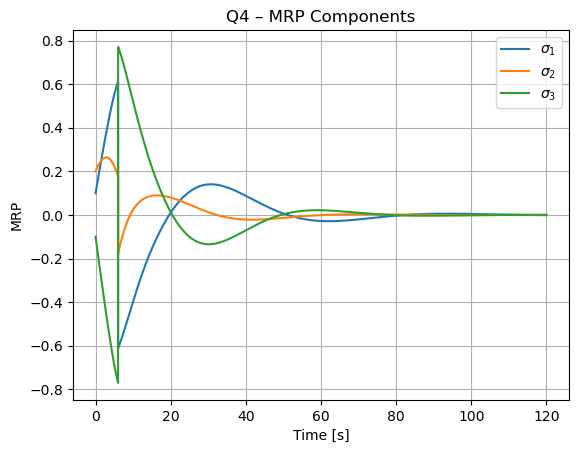

In [10]:
t = cc1q4_sim_result['t']
x = cc1q4_sim_result['x']
u = cc1q4_sim_result['u']
V = cc1q4_sim_result['V']

sigma = x[:, 0:3]
omega = x[:, 3:6]
omega_deg = np.rad2deg(omega)

plt.figure()
plt.plot(t, sigma[:, 0], label=r'$\sigma_1$')
plt.plot(t, sigma[:, 1], label=r'$\sigma_2$')
plt.plot(t, sigma[:, 2], label=r'$\sigma_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q4 – MRP Components")
plt.legend()
plt.show()

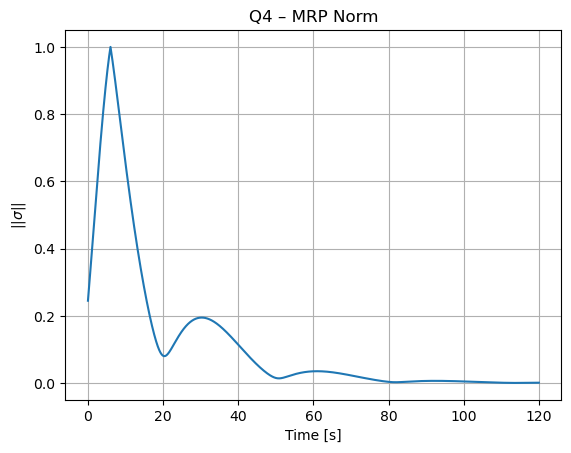

In [11]:
plt.figure()
plt.plot(t, np.linalg.norm(sigma, axis=1))
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel(r"$||\sigma||$")
plt.title("Q4 – MRP Norm")
plt.show()


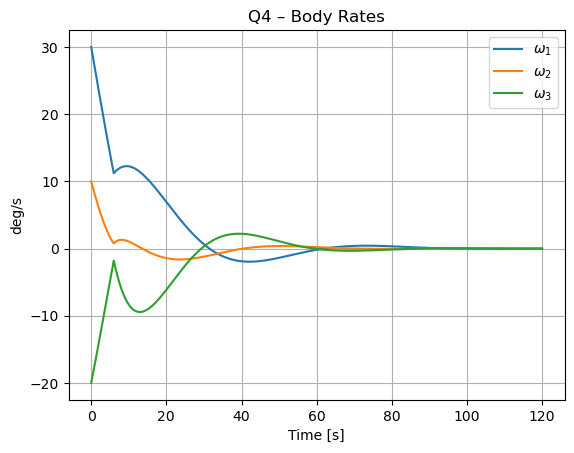

In [12]:
plt.figure()
plt.plot(t, omega_deg[:, 0], label=r'$\omega_1$')
plt.plot(t, omega_deg[:, 1], label=r'$\omega_2$')
plt.plot(t, omega_deg[:, 2], label=r'$\omega_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q4 – Body Rates")
plt.legend()
plt.show()

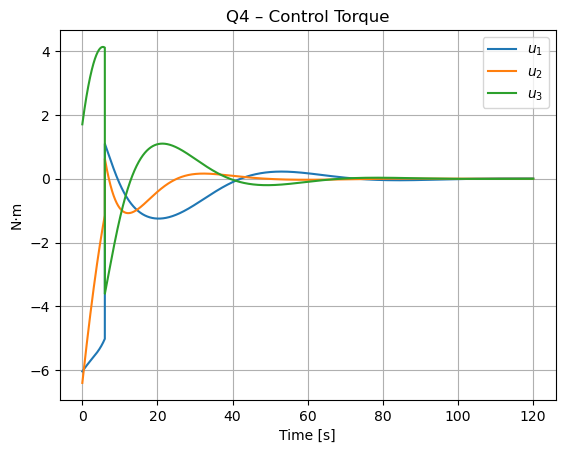

In [13]:
plt.figure()
plt.plot(t, u[:, 0], label=r'$u_1$')
plt.plot(t, u[:, 1], label=r'$u_2$')
plt.plot(t, u[:, 2], label=r'$u_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("N·m")
plt.title("Q4 – Control Torque")
plt.legend()
plt.show()


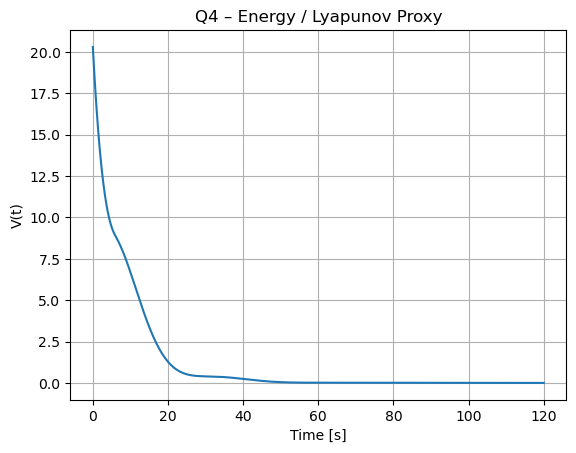

In [14]:
plt.figure()
plt.plot(t, V)
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("V(t)")
plt.title("Q4 – Energy / Lyapunov Proxy")
plt.show()


## CC1, Q5

In [15]:
def cc1_q5_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC1/Q5 attitude tracking controller.

    Inputs:
        state["sigma_BN"], state["omega_BN_B"]
        ref["sigma_RN"], ref["omega_RN_R"], ref["omega_dot_RN_R"]
        ctx["I"], ctx["K"], ctx["P"], ctx["L_B"] (optional; default zeros)

    Output:
        u_B: (3,) control torque in body frame B
    """
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    sigma_RN = np.asarray(ref["sigma_RN"], dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref["omega_RN_R"], dtype=float).reshape(3,)
    omega_dot_RN_R = np.asarray(ref["omega_dot_RN_R"], dtype=float).reshape(3,)

    I = np.asarray(ctx["I"], dtype=float).reshape(3, 3)
    K = float(ctx["K"])
    P = float(ctx["P"])
    L_B = np.asarray(ctx.get("L_B", np.zeros(3)), dtype=float).reshape(3,)

    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    omega_RN_B = C_BR @ omega_RN_R
    omega_dot_RN_B = C_BR @ omega_dot_RN_R
    omega_BR_B = omega_BN_B - omega_RN_B

    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + I @ (omega_dot_RN_B - np.cross(omega_BN_B, omega_RN_B))
        + np.cross(omega_BN_B, I @ omega_BN_B)
        - L_B
    )
    return u_B


In [16]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.0, 0.0, 0.0], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

context = {
    "I": I,
    "K": K,
    "P": P,
    "L_B": L
}

time_range = {
    "t0": 0.0,
    "tf": 120.0,
    "dt": 0.01,
}

initial_conditions = {
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}

ref = {
    "mode": "tracking",
    "f": 0.05,
}

report = {
    "time_s": 40.0,
    "quantity": "sigma_BR",
}

# --- Run ---
cc1q5_sim_result = simulate_CC(
    controller=cc1_q5_controller_u,
    state_derivative=cc_xdot_mrp,
    context=context,
    time_range=time_range,
    initial_conditions=initial_conditions,
    ref=ref,
    report=report,
)

cc1q5_sim_result

CC: ||sigma_B/R|| at t=40.000 s = 0.158824440175250


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102978,  0.20044435, -0.1013174 ,  0.52317894,  0.17427501,
         -0.34850358],
        [ 0.10205962,  0.20088729, -0.10263417,  0.52275878,  0.1740182 ,
         -0.34794107],
        ...,
        [-0.05652822,  0.28803467,  0.08422553,  0.06062813,  0.01184204,
         -0.02395373],
        [-0.05642969,  0.28807731,  0.0840797 ,  0.06063226,  0.01182167,
         -0.02396006],
        [-0.05633115,  0.28811987,  0.08393385,  0.06063638,  0.01180131,
         -0.02396637]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10102978,  0.20044435, -0.1013174 ],
        [ 0.10205962,  0.20088729, -0.10263417],
        ...,
        [-0.05652822,  0.28803467,  0.08422553],
        [-0.05642969,  0.28807731,  0.0840797 ],
        [-0.05633115,  0.288

In [17]:
t = cc1q5_sim_result["t"]
x = cc1q5_sim_result["x"]
sigma_BR = cc1q5_sim_result["sigma_BR"]
omega_BR = cc1q5_sim_result["omega_BR_B"]

sigma_BN = x[:, 0:3]
omega_BN = x[:, 3:6]
omega_BN_deg = np.rad2deg(omega_BN)

omega_BR_deg = np.rad2deg(omega_BR)

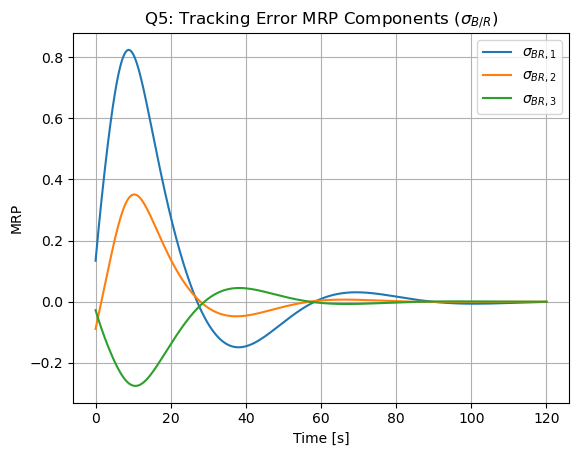

In [18]:
plt.figure()
plt.plot(t, sigma_BR[:, 0], label=r'$\sigma_{BR,1}$')
plt.plot(t, sigma_BR[:, 1], label=r'$\sigma_{BR,2}$')
plt.plot(t, sigma_BR[:, 2], label=r'$\sigma_{BR,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q5: Tracking Error MRP Components ($\\sigma_{B/R}$)")
plt.legend()
plt.show()


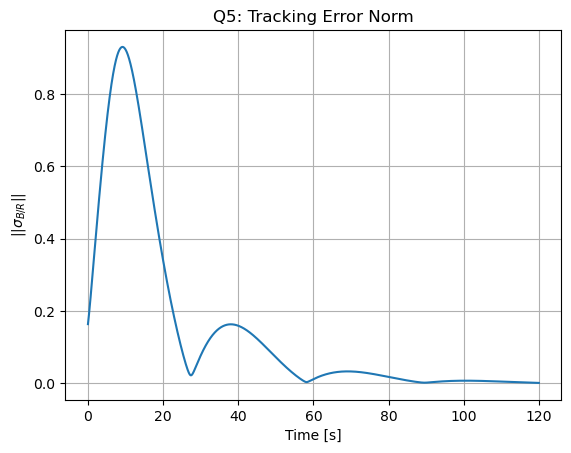

In [19]:
plt.figure()
plt.plot(t, np.linalg.norm(sigma_BR, axis=1))
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel(r"$||\sigma_{B/R}||$")
plt.title("Q5: Tracking Error Norm")
plt.show()


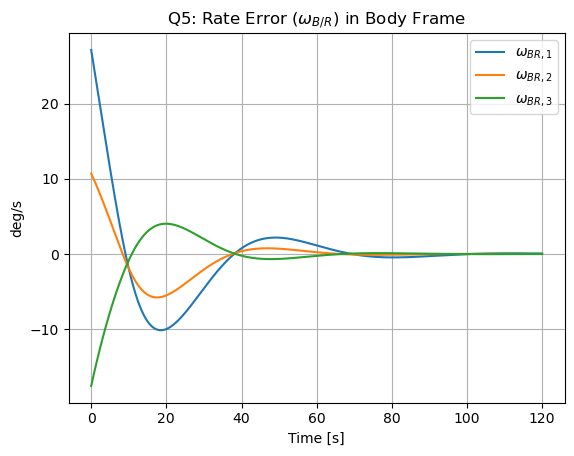

In [20]:
plt.figure()
plt.plot(t, omega_BR_deg[:, 0], label=r'$\omega_{BR,1}$')
plt.plot(t, omega_BR_deg[:, 1], label=r'$\omega_{BR,2}$')
plt.plot(t, omega_BR_deg[:, 2], label=r'$\omega_{BR,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q5: Rate Error ($\\omega_{B/R}$) in Body Frame")
plt.legend()
plt.show()


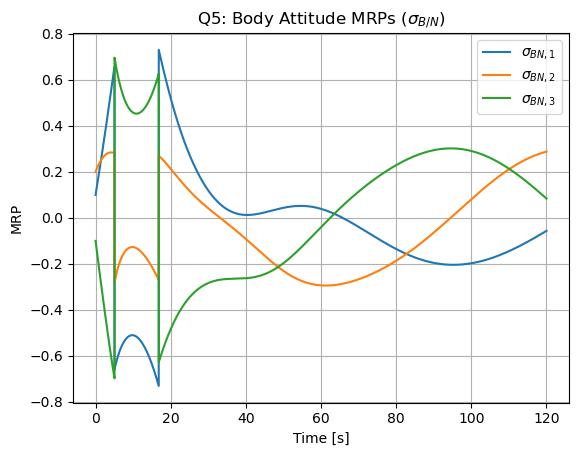

In [21]:
plt.figure()
plt.plot(t, sigma_BN[:, 0], label=r'$\sigma_{BN,1}$')
plt.plot(t, sigma_BN[:, 1], label=r'$\sigma_{BN,2}$')
plt.plot(t, sigma_BN[:, 2], label=r'$\sigma_{BN,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q5: Body Attitude MRPs ($\\sigma_{B/N}$)")
plt.legend()
plt.show()


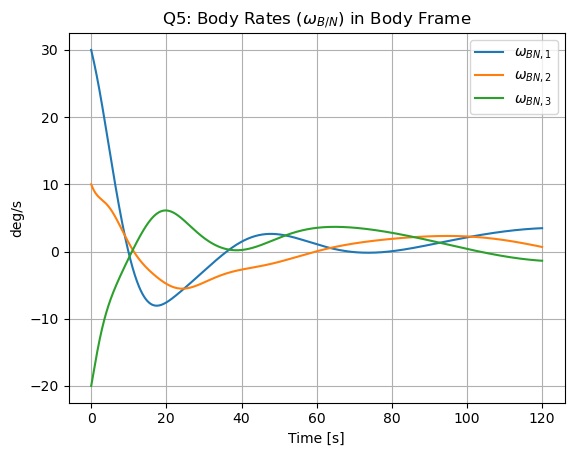

In [22]:
plt.figure()
plt.plot(t, omega_BN_deg[:, 0], label=r'$\omega_{BN,1}$')
plt.plot(t, omega_BN_deg[:, 1], label=r'$\omega_{BN,2}$')
plt.plot(t, omega_BN_deg[:, 2], label=r'$\omega_{BN,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q5: Body Rates ($\\omega_{B/N}$) in Body Frame")
plt.legend()
plt.show()


## CC2, Q5

In [23]:
def cc2_q5_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC2/Q5 attitude tracking controller (PD on attitude and rate error).

    Control law:
        u_B = -K * sigma_BR - P * omega_BR_B

    Inputs:
        state["sigma_BN"], state["omega_BN_B"]
        ref["sigma_RN"], ref["omega_RN_R"]
        ctx["K"], ctx["P"]

    Output:
        u_B: (3,) control torque expressed in body frame B
    """
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    sigma_RN = np.asarray(ref["sigma_RN"], dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref["omega_RN_R"], dtype=float).reshape(3,)

    K = float(ctx["K"])
    P = float(ctx["P"])

    # Attitude error
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # Rate error
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_BR_B = omega_BN_B - omega_RN_B

    u_B = -K * sigma_BR - P * omega_BR_B
    return u_B



In [24]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.0, 0.0, 0.0], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

context = {
    "I": I,
    "K": K,
    "P": P,
    "L_B": L
}


time_range = {
    "t0": 0.0,
    "tf": 120.0,
    "dt": 0.01,
}

initial_conditions = {
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}

ref = {
    "mode": "tracking",
    "f": 0.05,
}

report = {
    "time_s": 20.0,
    "quantity": "sigma_BR",
}

cc2q5_sim_results = simulate_CC(
    controller=cc2_q5_controller_u,
    state_derivative=cc_xdot_mrp,
    context=context,
    time_range=time_range,
    initial_conditions=initial_conditions,
    ref=ref,
    report=report,
)
cc2q5_sim_results


CC: ||sigma_B/R|| at t=20.000 s = 0.377862387698462


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102989,  0.20044504, -0.1013171 ,  0.52308769,  0.17482896,
         -0.3483798 ],
        [ 0.10206009,  0.20089004, -0.10263294,  0.52257656,  0.17512271,
         -0.34769394],
        ...,
        [-0.0673292 ,  0.3141675 ,  0.12502729,  0.06804106,  0.01167701,
         -0.0221562 ],
        [-0.06722017,  0.31422247,  0.12486535,  0.0680482 ,  0.0116588 ,
         -0.02216591],
        [-0.06711113,  0.31427737,  0.12470338,  0.06805532,  0.01164057,
         -0.02217561]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10102989,  0.20044504, -0.1013171 ],
        [ 0.10206009,  0.20089004, -0.10263294],
        ...,
        [-0.0673292 ,  0.3141675 ,  0.12502729],
        [-0.06722017,  0.31422247,  0.12486535],
        [-0.06711113,  0.314

## CC2, Q6

In [25]:
def cc2_q6_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC2/Q6 attitude tracking controller (PD + feedforward + gyro compensation).

    Control law:
        u_B = -K*sigma_BR - P*omega_BR_B
              + I*(omega_dot_RN_B - cross(omega_BN_B, omega_RN_B))
              + cross(omega_BN_B, I*omega_BN_B)

    Note:
        No "- L_B" term here (that appears in a later concept check).
        External torque L_B, if any, is modeled in the plant via ctx["L_B"].
    """
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    sigma_RN = np.asarray(ref["sigma_RN"], dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref["omega_RN_R"], dtype=float).reshape(3,)
    omega_dot_RN_R = np.asarray(ref["omega_dot_RN_R"], dtype=float).reshape(3,)

    I = np.asarray(ctx["I"], dtype=float).reshape(3, 3)
    K = float(ctx["K"])
    P = float(ctx["P"])

    # Attitude error
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # Map reference rate/accel into B
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_dot_RN_B = C_BR @ omega_dot_RN_R

    # Rate error
    omega_BR_B = omega_BN_B - omega_RN_B

    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + I @ (omega_dot_RN_B - np.cross(omega_BN_B, omega_RN_B))
        + np.cross(omega_BN_B, I @ omega_BN_B)
    )
    return u_B


In [26]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.5, -0.3, 0.2], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

context = {
    "I": I,
    "K": K,
    "P": P,
    "deltaL_B": L,  
}

time_range = {
    "t0": 0.0,
    "tf": 120.0,
    "dt": 0.01,
}

initial_conditions = {
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}

ref = {
    "mode": "tracking",
    "f": 0.05,
}

report = {
    "time_s": 80.0,
    "quantity": "sigma_BR",
}

# --- Run ---
cc2q6_sim_results = simulate_CC(
    controller=cc2_q6_controller_u,
    context=context,
    time_range=time_range,
    initial_conditions=initial_conditions,
    ref=ref,
    report=report,
)
cc2q6_sim_results

CC: ||sigma_B/R|| at t=80.000 s = 0.134442565551099


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102984,  0.20044428, -0.10131741,  0.52322891,  0.17423502,
         -0.3484786 ],
        [ 0.10205986,  0.20088702, -0.10263419,  0.52285864,  0.17393824,
         -0.34789116],
        ...,
        [ 0.06768015,  0.24358509,  0.06565066,  0.05365285, -0.0110419 ,
         -0.03860909],
        [ 0.0677612 ,  0.24358807,  0.06549111,  0.05365173, -0.01106381,
         -0.03860704],
        [ 0.06784224,  0.24359098,  0.06533156,  0.05365059, -0.01108571,
         -0.03860497]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10102984,  0.20044428, -0.10131741],
        [ 0.10205986,  0.20088702, -0.10263419],
        ...,
        [ 0.06768015,  0.24358509,  0.06565066],
        [ 0.0677612 ,  0.24358807,  0.06549111],
        [ 0.06784224,  0.243

## CC2, Q7

In [27]:
def cc2_q7_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC2/Q7 attitude tracking controller (PD + feedforward + gyro compensation + disturbance cancelation).

    Control law:
        u_B = -K*sigma_BR - P*omega_BR_B
              + I*(omega_dot_RN_B - cross(omega_BN_B, omega_RN_B))
              + cross(omega_BN_B, I*omega_BN_B)
              - L_B

    Inputs:
        state["sigma_BN"], state["omega_BN_B"]
        ref["sigma_RN"], ref["omega_RN_R"], ref["omega_dot_RN_R"]
        ctx["I"], ctx["K"], ctx["P"], ctx["L_B"]

    Output:
        u_B: (3,) control torque expressed in body frame B
    """
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    sigma_RN = np.asarray(ref["sigma_RN"], dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref["omega_RN_R"], dtype=float).reshape(3,)
    omega_dot_RN_R = np.asarray(ref["omega_dot_RN_R"], dtype=float).reshape(3,)

    I = np.asarray(ctx["I"], dtype=float).reshape(3, 3)
    K = float(ctx["K"])
    P = float(ctx["P"])
    L_B = np.asarray(ctx.get("L_B", np.zeros(3)), dtype=float).reshape(3,)

    # Attitude error
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # Map reference rate/accel into body frame B
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_dot_RN_B = C_BR @ omega_dot_RN_R

    # Rate error
    omega_BR_B = omega_BN_B - omega_RN_B

    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + I @ (omega_dot_RN_B - np.cross(omega_BN_B, omega_RN_B))
        + np.cross(omega_BN_B, I @ omega_BN_B)
        - L_B
    )
    return u_B


In [28]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.5, -0.3, 0.2], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

context = {
    "I": I,
    "K": K,
    "P": P,
    "modelL_B": L
}

time_range = {
    "t0": 0.0,
    "tf": 120.0,
    "dt": 0.01,
}

initial_conditions = {
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}

ref = {
    "mode": "tracking",
    "f": 0.05,
}

report = {
    "time_s": 70.0,
    "quantity": "sigma_BR",
}

# --- Run ---
cc2q7_sim_results = simulate_CC(
    controller=cc2_q7_controller_u,
    state_derivative=cc_xdot_mrp,
    context=context,
    time_range=time_range,
    initial_conditions=initial_conditions,
    ref=ref,
    report=report,
)
cc2q7_sim_results

CC: ||sigma_B/R|| at t=70.000 s = 0.032210380258409


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102978,  0.20044435, -0.1013174 ,  0.52317894,  0.17427501,
         -0.34850358],
        [ 0.10205962,  0.20088729, -0.10263417,  0.52275878,  0.1740182 ,
         -0.34794107],
        ...,
        [-0.05652822,  0.28803467,  0.08422553,  0.06062813,  0.01184204,
         -0.02395373],
        [-0.05642969,  0.28807731,  0.0840797 ,  0.06063226,  0.01182167,
         -0.02396006],
        [-0.05633115,  0.28811987,  0.08393385,  0.06063638,  0.01180131,
         -0.02396637]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10102978,  0.20044435, -0.1013174 ],
        [ 0.10205962,  0.20088729, -0.10263417],
        ...,
        [-0.05652822,  0.28803467,  0.08422553],
        [-0.05642969,  0.28807731,  0.0840797 ],
        [-0.05633115,  0.288

## CC3

In [29]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.5, -0.3, 0.2], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

context = {
    "I": I,
    "K": K,
    "P": P,
    "deltaL_B": L
}

time_range = {
    "t0": 0.0,
    "tf": 120.0,
    "dt": 0.01,
}

initial_conditions = {
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}

ref = {
    "mode": "regulator",  # regulator mode
    "f": 0.0,             # unused for regulator problems
}

report = {
    "time_s": 35.0,
    "quantity": "sigma_BR",
}

# --- Run ---
cc3_sim_results = simulate_CC(
    controller=cc2_q6_controller_u,
    state_derivative=cc_xdot_mrp,
    context=context,
    time_range=time_range,
    initial_conditions=initial_conditions,
    ref=ref,
    report=report,
)
cc3_sim_results

CC: ||sigma_B/R|| at t=35.000 s = 0.276957350317444


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01,
          5.23598776e-01,  1.74532925e-01, -3.49065850e-01],
        [ 1.01029590e-01,  2.00444196e-01, -1.01317424e-01,
          5.23075181e-01,  1.74127004e-01, -3.48541934e-01],
        [ 1.02058872e-01,  2.00886667e-01, -1.02634253e-01,
          5.22551596e-01,  1.73721328e-01, -3.48017849e-01],
        ...,
        [ 9.70826875e-02, -5.99775604e-02,  4.21439839e-02,
          6.45167214e-04,  8.43179128e-04, -3.16803472e-04],
        [ 9.70841945e-02, -5.99751947e-02,  4.21438048e-02,
          6.45979920e-04,  8.42039900e-04, -3.17746812e-04],
        [ 9.70857042e-02, -5.99728311e-02,  4.21436231e-02,
          6.46791060e-04,  8.40900615e-04, -3.18688861e-04]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10102959,  0.2004442 , -0.10131742],
        [ 0.10205887,  0.20088667, -0.102634

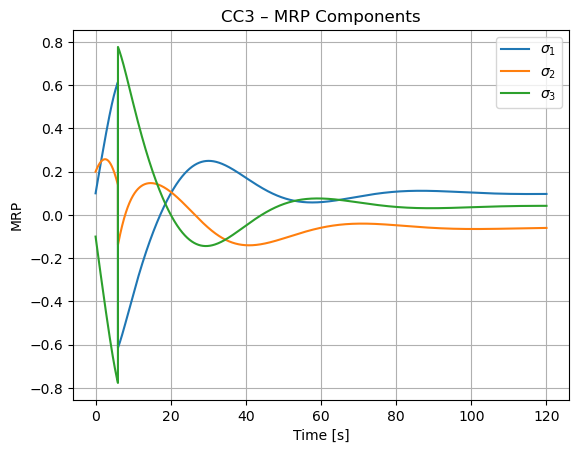

In [30]:
t = cc3_sim_results['t']
x = cc3_sim_results['x']
u = cc3_sim_results['u']
V = cc3_sim_results['V']

sigma = x[:, 0:3]
omega = x[:, 3:6]
omega_deg = np.rad2deg(omega)

plt.figure()
plt.plot(t, sigma[:, 0], label=r'$\sigma_1$')
plt.plot(t, sigma[:, 1], label=r'$\sigma_2$')
plt.plot(t, sigma[:, 2], label=r'$\sigma_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("CC3 – MRP Components")
plt.legend()
plt.show()

In [31]:
cc3_sim_results["sigma_BR"][-1]

array([ 0.0970857 , -0.05997283,  0.04214362])

## CC4

In [32]:
def cc4_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC4 nonlinear attitude tracking controller with integral action.

    State:
        state["sigma_BN"]     : MRPs of body B relative to inertial N
        state["omega_BN_B"]   : angular rate of B wrt N, expressed in B [rad/s]

    Reference:
        ref["sigma_RN"]        : MRPs of reference R relative to inertial N
        ref["omega_RN_R"]      : angular rate of R wrt N, expressed in R [rad/s]
        ref["omega_dot_RN_R"]  : angular accel of R wrt N, expressed in R [rad/s^2]

    Context (required/optional):
        ctx["I"]  : inertia matrix in B
        ctx["K"]  : attitude gain (scalar)
        ctx["P"]  : rate gain (scalar)
        ctx["Ki"] : integral gain (scalar)  (or can be 3-vector if you prefer)
        ctx["integral_sigma_BR"] : integral memory eta = ∫ sigma_BR dt  (updated in simulate_CC)

        ctx["modelL_B"] : modeled/known disturbance torque in B (default zero)

        Optional (to mimic that other repo more closely):
        ctx["integral_form"] : "simple" (default) or "z"
        ctx["omega_BR0_B"]   : initial omega_BR_B for the "z" form (default zeros)
        ctx["omega_BN_feedback_for_comp"] : if True uses omega_BN_B in the transport term (default True)

    Output:
        u_B : control torque in B [N*m]
    """
    # --- unpack state ---
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    # --- unpack reference ---
    sigma_RN = np.asarray(ref.get("sigma_RN", np.zeros(3)), dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref.get("omega_RN_R", np.zeros(3)), dtype=float).reshape(3,)
    omega_dot_RN_R = np.asarray(ref.get("omega_dot_RN_R", np.zeros(3)), dtype=float).reshape(3,)

    # --- unpack context ---
    I = np.asarray(ctx["I"], dtype=float).reshape(3, 3)
    K = float(ctx["K"])
    P = float(ctx["P"])
    Ki = ctx.get("Ki", 0.0)
    Ki = np.asarray(Ki, dtype=float)  # allow scalar or vec(3) broadcasting
    modelL_B = np.asarray(ctx.get("modelL_B", np.zeros(3)), dtype=float).reshape(3,)

    # integral memory (eta = ∫ sigma_BR dt) must be updated once per dt in simulate_CC
    eta = np.asarray(ctx.get("integral_sigma_BR", np.zeros(3)), dtype=float).reshape(3,)

    # -------------------------
    # 1) Attitude error sigma_BR
    # -------------------------
    # sigma_BR = sigma_BN (-) sigma_RN
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # -------------------------
    # 2) Rate error omega_BR_B
    # -------------------------
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_BR_B = omega_BN_B - omega_RN_B

    # -------------------------
    # 3) Feedforward/transport compensation term (tracking)
    # -------------------------
    # Map reference angular acceleration into B
    omega_dot_RN_B = C_BR @ omega_dot_RN_R

    # Transport term: (omega_BN_B x omega_RN_B)
    # Using omega_BN_B is consistent with the common form:
    #   I*(omega_dot_RN_B - omega_BN_B×omega_RN_B)
    transport = np.cross(omega_BN_B, omega_RN_B)

    ff = I @ (omega_dot_RN_B - transport)

    # -------------------------
    # 4) Integral term
    # -------------------------

    # Mimic the other repo's structure:
    #   dw = omega_BR - omega_BR0
    #   z  = K*eta + I*dw
    #   u += -(P*Ki)*z
    omega_BR0_B = np.asarray(ctx.get("omega_BR0_B", np.zeros(3)), dtype=float).reshape(3,)
    dw = omega_BR_B - omega_BR0_B
    z = (K * eta) + (I @ dw)

    # -------------------------
    # 5) Final control law
    # -------------------------
    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + ff
        + np.cross(omega_BN_B, I @ omega_BN_B)   # gyro cancellation
        -(P * Ki) * z
        - modelL_B                               # disturbance model compensation (if known)
    )

    return u_B


In [33]:
# --- Parameters ---
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
Ki_q2 = 0.005  # (use this for the CC4 run if that's what your controller expects)
Ki_q4 = 0.0    # unused here unless you explicitly switch gains

deltaL_B = np.array([0.5, -0.3, 0.2], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1], dtype=float)
omega0_deg = np.array([3.0, 1.0, -2.0], dtype=float)

eta0 = np.zeros(3)

# --- Grouped inputs (new interface) ---
context = {
    "I": I,
    "K": K,
    "P": P,
    "Ki": Ki_q4,

    "deltaL_B": deltaL_B,          # actual plant disturbance (aliased to L_B internally)
    "modelL_B": np.zeros(3),       # controller assumes no disturbance
}

time_range = {
    "t0": 0.0,
    "tf": 240.0,
    "dt": 0.01,
}

initial_conditions = {
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
    "eta0": eta0,                  # initializes integral memory (eta = ∫ sigma_BR dt)
}

ref = {
    "mode": "tracking",
    "f": 0.05,
}

report = {
    "time_s": 35.0,
    "quantity": "sigma_BR",
}

# --- Run ---
cc4_sim_results = simulate_CC(
    controller=cc4_controller_u,
    state_derivative=cc_xdot_mrp,
    context=context,
    time_range=time_range,
    initial_conditions=initial_conditions,
    ref=ref,
    report=report,
)

cc4_sim_results


CC: ||sigma_B/R|| at t=35.000 s = 0.120210408657033


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 2.3998e+02, 2.3999e+02,
        2.4000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.05235988,  0.01745329,
         -0.03490659],
        [ 0.10010299,  0.20004443, -0.10013171,  0.0523554 ,  0.01740952,
         -0.03484859],
        [ 0.100206  ,  0.20008871, -0.10026331,  0.05235092,  0.01736573,
         -0.03479066],
        ...,
        [ 0.02262752,  0.22687483,  0.1509715 ,  0.05057502,  0.00255231,
         -0.03660422],
        [ 0.02270063,  0.22691871,  0.15082686,  0.05057913,  0.00253028,
         -0.03660999],
        [ 0.02277375,  0.22696251,  0.1506822 ,  0.05058323,  0.00250826,
         -0.03661575]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10010299,  0.20004443, -0.10013171],
        [ 0.100206  ,  0.20008871, -0.10026331],
        ...,
        [ 0.02262752,  0.22687483,  0.1509715 ],
        [ 0.02270063,  0.22691871,  0.15082686],
        [ 0.02277375,  0.226

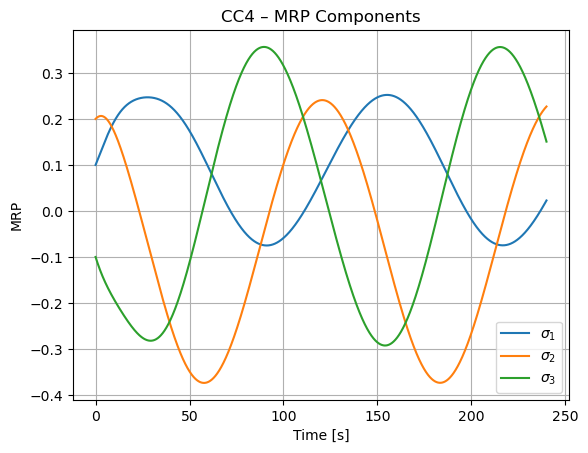

In [34]:
t = cc4_sim_results['t']
x = cc4_sim_results['x']
u = cc4_sim_results['u']
V = cc4_sim_results['V']

sigma_BN = cc4_sim_results['sigma_BN']

sigma = x[:, 0:3]
omega = x[:, 3:6]
omega_deg = np.rad2deg(omega)

plt.figure()
plt.plot(t, sigma_BN[:, 0], label=r'$\sigma_1$')
plt.plot(t, sigma_BN[:, 1], label=r'$\sigma_2$')
plt.plot(t, sigma_BN[:, 2], label=r'$\sigma_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("CC4 – MRP Components")
plt.legend()
plt.show()

In [35]:
cc4_sim_results['z'][-1]

array([121.06305129, -73.81835205,  45.59983815])

## CC5

In [36]:
def cc5_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC5 nonlinear attitude regulator (diagonal rate gains).

    Implements:
        u = -K*sigma_BN - P*omega_BN_B + omega×(I*omega)

    Notes
    -----
    - This is a regulation controller: reference is zero attitude and zero rate.
    - The gyro-comp term +omega×(I*omega) cancels the plant's nonlinear term
      so the linearized closed-loop looks like decoupled 2nd-order axes.
    - ctx["P"] may be:
        - scalar (same on all axes), or
        - length-3 vector (P1,P2,P3), or
        - 3x3 diagonal matrix.
    """
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    I = np.asarray(ctx["I"], dtype=float).reshape(3, 3)
    K = float(ctx["K"])
    P = ctx["P"]

    # Make P act like a diagonal gain
    P = np.asarray(P, dtype=float)
    if P.ndim == 0:
        P_vec = np.full(3, float(P))
    elif P.shape == (3,):
        P_vec = P
    elif P.shape == (3, 3):
        P_vec = np.diag(P)
    else:
        raise ValueError("ctx['P'] must be scalar, (3,), or (3,3)")

    u_B = (
        -K * sigma_BN
        -P @ omega_BN_B
        + np.cross(omega_BN_B, I @ omega_BN_B)
    )
    return u_B


In [37]:
# CC5, Q1
# Given
I = np.diag([100.0, 75.0, 80.0])
K = 5.0


# For MRPs near zero: sigma_dot = 0.25 * omega
# Linearized closed-loop per axis: sigma_ddot + (P_i/I_i)*sigma_dot + (K/(4 I_i))*sigma = 0
# Match to: x_ddot + 2*zeta*wn*x_dot + wn^2*x = 0
# => wn^2 = K/(4 I_i), and 2*zeta*wn = P_i/I_i
# For critical damping (zeta=1): P_i = 2 I_i wn = sqrt(I_i*K)
P = np.sqrt(I * K)

P_diag = np.diag(P)

print(f"GainList, P = {P_diag}")

context = {
    "I": I,
    "K": K,
    "P": P,          # <-- vector diag gains from Q1
    "deltaL_B": np.zeros(3),  # unperturbed
    "modelL_B": np.zeros(3),
}

time_range = {"t0": 0.0, "tf": 120.0, "dt": 0.01}
initial_conditions = {
    "sigma0": np.array([0.1, 0.2, -0.1]),
    "omega0_deg": np.array([30.0, 10.0, -20.0]),
}
ref = {"mode": "regulator", "f": 0.0}
report = {"time_s": 30.0, "quantity": "sigma_BN"}  # or "sigma_BR"

cc5_sim_results = simulate_CC(
    controller=cc5_controller_u,
    state_derivative=cc_xdot_mrp,
    context=context,
    time_range=time_range,
    initial_conditions=initial_conditions,
    ref=ref,
    report=report,
)
cc5_sim_results


GainList, P = [22.36067977 19.36491673 20.        ]
CC: ||sigma_B/N|| at t=30.000 s = 0.132948895647910


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01,
          5.23598776e-01,  1.74532925e-01, -3.49065850e-01],
        [ 1.01028895e-01,  2.00443986e-01, -1.01316601e-01,
          5.22379080e-01,  1.73949555e-01, -3.48131443e-01],
        [ 1.02056096e-01,  2.00885831e-01, -1.02630959e-01,
          5.21161595e-01,  1.73367394e-01, -3.47198547e-01],
        ...,
        [ 1.20716897e-05, -6.85312683e-07, -4.56733857e-06,
         -5.02943642e-06,  3.22629874e-07,  2.13806128e-06],
        [ 1.20591226e-05, -6.84506593e-07, -4.56199653e-06,
         -5.02422879e-06,  3.22253939e-07,  2.13557215e-06],
        [ 1.20465685e-05, -6.83701442e-07, -4.55666070e-06,
         -5.01902651e-06,  3.21878437e-07,  2.13308591e-06]]),
 'sigma_BN': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01],
        [ 1.01028895e-01,  2.00443986e-01, -1.01316601e-01],
        [ 1.02056096

In [38]:
wn = np.sqrt(K / (4.0 * np.diag(I)))   # rad/s
T = 1.0 / wn                       # seconds

T.tolist()  # [T1, T2, T3]


[8.94427190999916, 7.745966692414835, 8.0]

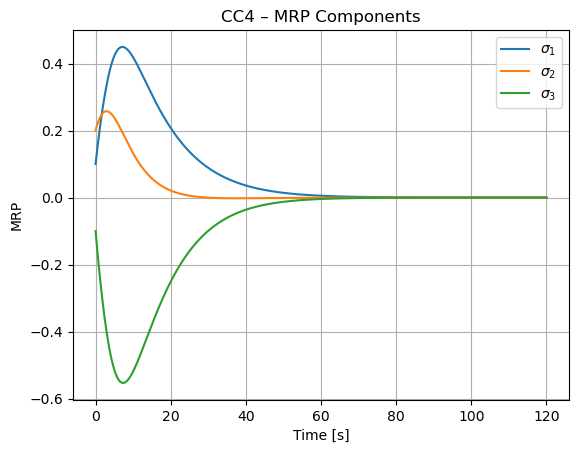

In [39]:
t = cc5_sim_results['t']
x = cc5_sim_results['x']
u = cc5_sim_results['u']
V = cc5_sim_results['V']

sigma_BN = cc5_sim_results['sigma_BN']

sigma = x[:, 0:3]
omega = x[:, 3:6]
omega_deg = np.rad2deg(omega)

plt.figure()
plt.plot(t, sigma_BN[:, 0], label=r'$\sigma_1$')
plt.plot(t, sigma_BN[:, 1], label=r'$\sigma_2$')
plt.plot(t, sigma_BN[:, 2], label=r'$\sigma_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("CC4 – MRP Components")
plt.legend()
plt.show()